# Design Project 1: Single-Gimbal Control Moment Gyroscope (CMG)


### Conan Zhang and Harshitha Thota

In [1]:
# Package Imports!
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from scipy import signal
init_printing()

# System Dynamics and Equations of Motion

First we define our constants, variables, functions, equations, and system model.

### Constants

In [2]:
# Constants of the system
mp = 0.5      # Mass of the sphere on the top of the frame
ixx = 0.03    # Lateral mass moment of inertia of the gimbal
izz = 0.04    # Longitudinal mass moment of inertia of the gimbal
l = 1.5       # Distance from the center of the gimbal to the center of the sphere on top of the frame
g = 9.81      # Acceleration due to gravity
rotor_velocity = 100.0 # Fixed angular rate of the gimbal in rad/sec

### Variable & Functions

In [3]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time. Thus they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau')

### Equations of Motion

In [4]:
# Get the position of the mass
pos = Matrix([-l*sin(theta(t)),
              0.0,
              l*cos(theta(t))])

In [5]:
# Take the derivative of position with respect to time
vel = diff(pos,t)

In [6]:
# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

In [7]:
# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

In [8]:
# The is the rotational rate of the gimbal
gimbal_rate = Matrix([Derivative(phi(t), t),
                      Derivative(theta(t), t)*cos(phi(t)),
                      rotor_velocity - Derivative(theta(t), t)*sin(phi(t))])

In [9]:
# This is the mass moment of inertia of the gimbal
I = Matrix([[ixx, 0.0, 0.0],
            [0.0, ixx, 0.0],
            [0.0, 0.0, izz]])

In [10]:
# Calculate the rotational energy of the gimbal
gimbal_RE = (0.5 * (gimbal_rate.T @ I @ gimbal_rate))[0, 0]

### Lagrangian Equations

In [11]:
# Get the lagrangian
L = (mass_KE + gimbal_RE) - mass_PE
print("System Lagrangian:")
L = simplify(L)
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

System Lagrangian:


In [12]:
# Get the first equation of motion
eq1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

In [13]:
# Get the second equation of motion
eq2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - tau(t)

In [14]:
# Make the new functions for change of variables
omega_theta = Function('omega_theta')
omega_phi = Function('omega_phi')

In [15]:
# Make the change of variables for equation 1
eq1 = eq1.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})
eq1

In [16]:
# Repeat for equation 2
eq2 = eq2.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})
eq2

### System Model

In [17]:
# Solve the equations for Derivative(omega_theta(t), t) and Derivative(omega_phi(t), t)
soln = solve([eq1, eq2],
              Derivative(omega_theta(t), t),
              Derivative(omega_phi(t), t))

In [18]:
# Build the equations of motion vector
f = Matrix([soln[Derivative(omega_theta(t), t)],
            soln[Derivative(omega_phi(t), t)],
            omega_theta(t),
            omega_phi(t)])

# Replace the functions of time with symbols
(v1, v2, v3, v4, v5) = symbols('v1, v2, v3, v4, v5')
f = f.subs({omega_theta(t) : v1,
            omega_phi(t) : v2,
            theta(t) : v3,
            phi(t) : v4,
            tau(t) : v5})
(omega_theta, omega_phi, theta, phi, tau) = symbols('omega_theta, omega_phi, theta, phi, tau')
f = f.subs({v1 : omega_theta,
            v2 : omega_phi,
            v3 : theta,
            v4 : phi,
            v5 : tau})

# Simplify
f = simplify(f)

In [19]:
N(f, 3) #prints our system model with respect to 3 decimal places

⎡-4.0⋅ωᵩ⋅ωₜₕₑₜₐ⋅sin(2⋅φ) + 1.6e+3⋅ωᵩ⋅cos(φ) + 2.94e+3⋅sin(θ)⎤
⎢───────────────────────────────────────────────────────────⎥
⎢                           2                               ⎥
⎢                    4.0⋅sin (φ) + 462.0                    ⎥
⎢                                                           ⎥
⎢               2                                           ⎥
⎢   0.167⋅ωₜₕₑₜₐ ⋅sin(2⋅φ) - 133.0⋅ωₜₕₑₜₐ⋅cos(φ) + 33.3⋅τ   ⎥
⎢                                                           ⎥
⎢                          ωₜₕₑₜₐ                           ⎥
⎢                                                           ⎥
⎣                            ωᵩ                             ⎦

# System Linearization and State Space Form

Next we will set up our equilibrium points and find matrices A and B for our space state model through linearization.

In [20]:
# 0's for all our variables are valid equilibrium points 
(omega_theta, omega_phi) = symbols('omega_theta, omega_phi')

f = Matrix([f[0],
                f[1],
                omega_theta,
                omega_phi])

f_num = lambdify([omega_theta, omega_phi, theta, phi, tau], f)

omega_theta_e = 0
omega_phi_e = 0
theta_e = 0
phi_e = 0 #or np.pi
tau_e = 0

f_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

array([[0.],
       [0.],
       [0.],
       [0.]])

In [21]:
A_num = lambdify([omega_theta, omega_phi, theta, phi, tau], f.jacobian([omega_theta, omega_phi, theta, phi]))
A = A_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e).astype(float)

B_num = lambdify([omega_theta, omega_phi, theta, phi, tau], f.jacobian([tau]))
B = B_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e).astype(float)

print(A)

[[  -0.            3.46320346    6.37012987   -0.        ]
 [-133.33333333    0.            0.            0.        ]
 [   1.            0.            0.            0.        ]
 [   0.            1.            0.            0.        ]]


In [22]:
print(B)

[[ 0.        ]
 [33.33333333]
 [ 0.        ]
 [ 0.        ]]


# Gain Selection and Controller Design

After much brute force, these eigenvalues were determined to yield a stable system for a set of intial conditions defined later. Pole placement was used to yield a gain_matrix from these eigenvalues. 

In [23]:
#eigenvalues of -55 -10 -1 -5
eigvals = np.array([-55, -10, -1, -5])
pp = signal.place_poles(A,B,eigvals)
K = pp.gain_matrix
K[0]

array([  7.98086531,   2.13      ,  35.31943125, -12.95107034])

In [24]:
# Create the Controller class
class Controller():
    def __init__(self):
        pass
    
    def reset(self):
        pass 

    
    def run(self, **kwargs):
        #x: state
        x = np.array([kwargs['frame_velocity'], 
                      kwargs['gimbal_velocity'],
                      kwargs['frame_angle'], 
                      kwargs['gimbal_angle']])
        #u: input
        u = -K@x
        torque = [u[0]]
        return torque

In [25]:
# Create an instance of our Controller class
controller = Controller()

# Running the simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [26]:
#Importing this this module helps simulate, render, and plot the dynamic system
import ae353_cmg

In [27]:
# Creates an instance of the cart simulator
sim = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Now we can begin running the simulation with our controller to collect the simulation data. We plot the pendulum versus time as well as the applied torque versus time. A successfully implemented controller should yield a closed-loop system that is asymptotically stable (reaches equilibrium) in simulation. We can graph plots to make sense of the simulation data. In each simulation, we plot the 1) pendulum versus time as well as 2) the applied torque versus time.

## Simulation 1

In [28]:
#intial frame angle increased from 0 -> pi/12
data = sim.run(controller,
               max_time = 15.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 0.0,
               rotor_velocity = rotor_velocity,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


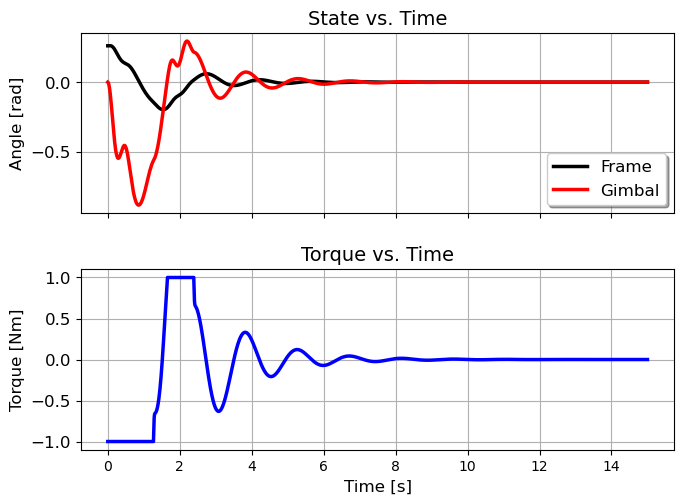

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the frame and gimbal angles versus time on the first plot
axes[0].plot(data['time'], data['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].plot(data['time'], data['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data['time'], data['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

After much brute force and simulation trial and error, we found that our gain_matrix found earlier and an initial phi angle of pi/12 yielded a stable system as the torque and frame & gimbal angles reached 0.

## Simulation 2

In [30]:
# Creates an instance of the cart simulator
sim1 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Termination command detected. Terminating keyboard listener. Goodbye


In [31]:
#initial frame angle increases from pi/12 -> pi/11
controller.reset()
data1 = sim1.run(controller,
               max_time = 15.0,
               initial_frame_angle = np.pi/11,
               initial_gimbal_angle = 0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 0.0,
               rotor_velocity = rotor_velocity,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


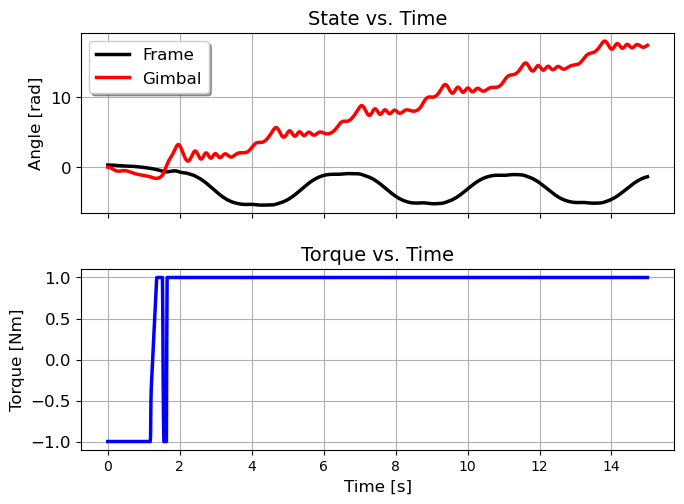

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the frame and gimbal angles versus time on the first plot
axes[0].plot(data1['time'], data1['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].plot(data1['time'], data1['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data1['time'], data1['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

As the frame angle deviates only slightly from a stable initial condition (pi/12 -> pi/11), the entire system becomes asymptotically unstable. This suggests that the system must have initial conditions close to equilibrium in order to be stable (in this case phi_angle must be close to 0). This could also suggest that our gains_matrix wasn't as strong as we thought.

## Simulation 3

In [33]:
# Creates an instance of the cart simulator
sim2 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [34]:
#initial frame_velocity increased from 0.0 -> 3.0
data2 = sim2.run(controller,
               max_time = 15.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 3.0,
               initial_gimbal_velocity = 0.0,
               rotor_velocity = rotor_velocity,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


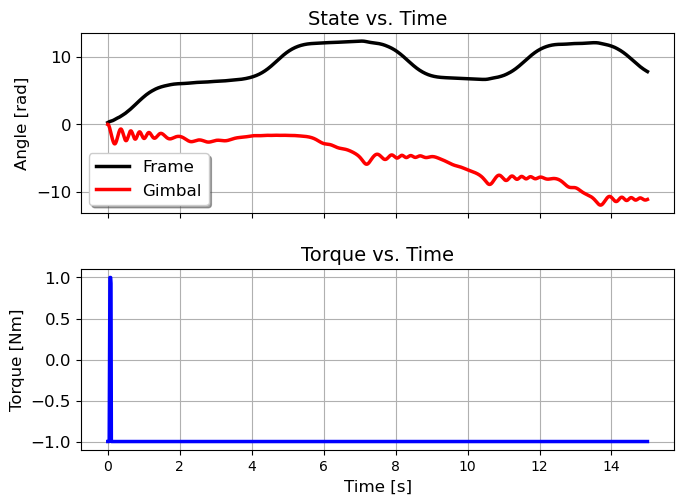

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the frame and gimbal angles versus time on the first plot
axes[0].plot(data2['time'], data2['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].plot(data2['time'], data2['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data2['time'], data2['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

In the presence of an intial frame velocity, the controller fails to stabilize suggesting that the intial gain_matrix found was not perfect in generating a asympotically stable system. The Gyroscope fails to reach equilibrium about 0.

## Simulation 4

In [36]:
# Creates an instance of the cart simulator
sim3 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [37]:
#initial gimbal velocity increased from 0.0 -> 1.0
data3 = sim3.run(controller,
               max_time = 15.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 1.0,
               rotor_velocity = rotor_velocity,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


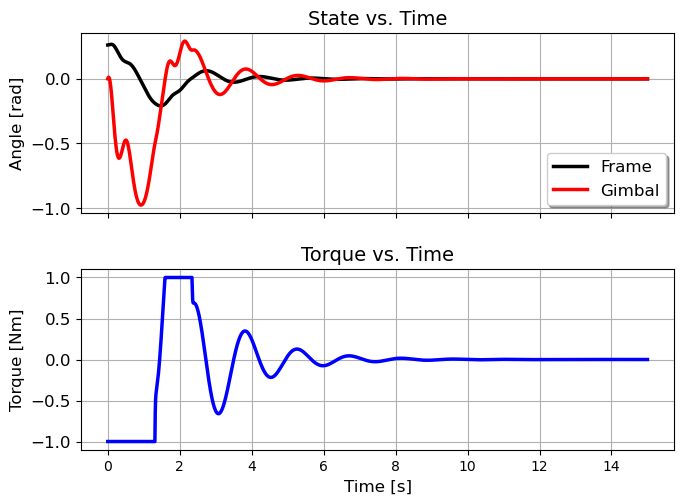

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the frame and gimbal angles versus time on the first plot
axes[0].plot(data3['time'], data3['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].plot(data3['time'], data3['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data3['time'], data3['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

Giving the gimbal an inital velocity of 1 rad/s, the simulated gyroscope still managed to reach equilibrium. This observation suggests that the gains_matrix and controller chosen still has some credibility and use for building a closed-loop stable system given an different set of intial conditions. Upon increasing the gimbal velocity further, the system could still collapse.

## Simulation 5

In [39]:
# Creates an instance of the cart simulator
sim4 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [40]:
#rotor velocity increased from 100 -> 200
data4 = sim4.run(controller,
               max_time = 15.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 1.0,
               rotor_velocity = 200,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


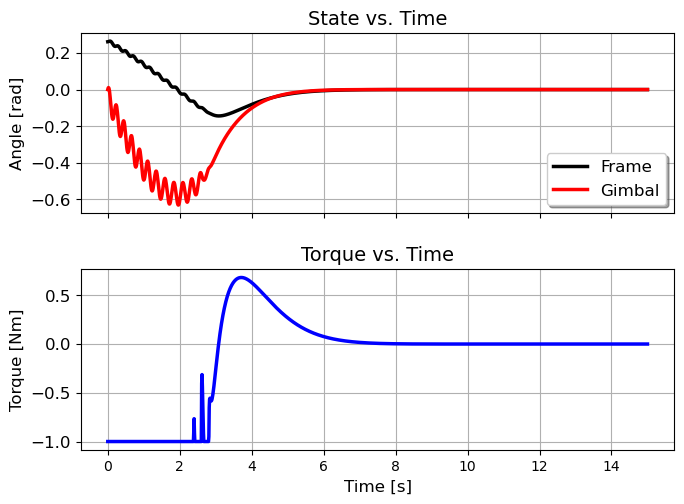

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the frame and gimbal angles versus time on the first plot
axes[0].plot(data4['time'], data4['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].plot(data4['time'], data4['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data4['time'], data4['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

Upon doubling the rotor velocity from 100 rad/s to 200 rad/s, the controller still brought the gyroscope to equilibrium.

## Conclusion
In 3 out of 5 trials of varying initial parameters, the controller managed to bring the gyroscope to equilibrium. However, these parameters were only subtle changes from the initial simulation where only the frame angle was changed. Any more increase in rotor velocity or gimbal velocity could still cause our system to diverge. Overall, our controller may be useful for single-gimbal CMGs in a future space mission, but anyone utilizing these observations/data might want to proceed with caution.